# Imports

In [2]:
import os, sys
import numpy as np
import healpy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import medfilt
from astropy.table import Table, vstack, join
from astropy.io import fits

import desispec.io
from desispec.interpolation import resample_flux
from desispec.resolution import Resolution
from desispec.spectra import Spectra

from desisim.templates import BGS, ELG
from desisim.scripts.quickspectra import sim_spectra
from desisim.io import read_basis_templates

from redrock.external.desi import rrdesi
import redrock.templates
import redrock.results
from redrock.external import desi

import time

%matplotlib inline
sns.set(context='talk', palette='Dark2', style='ticks')

# Analysis

In [3]:
# Read data into astropy tables

# Read in Truth Data
truthdata = Table.read(os.path.join(os.getcwd(), '..', 'lenssource-truth.fits'))

# Read in lens+source zbest 
zbest_lens = Table.read(os.path.join(os.getcwd(), '..', 'lenssource-zbest.fits'))

# Read in shortened truth data
truthdata_ELG = Table.read(os.path.join(os.getcwd(), '..', 'source-truth.fits'))

# Read in source zbest
zbest_source = Table.read(os.path.join(os.getcwd(), '..', 'source-zbest.fits'))

(0.0, 1.3999689817428589)

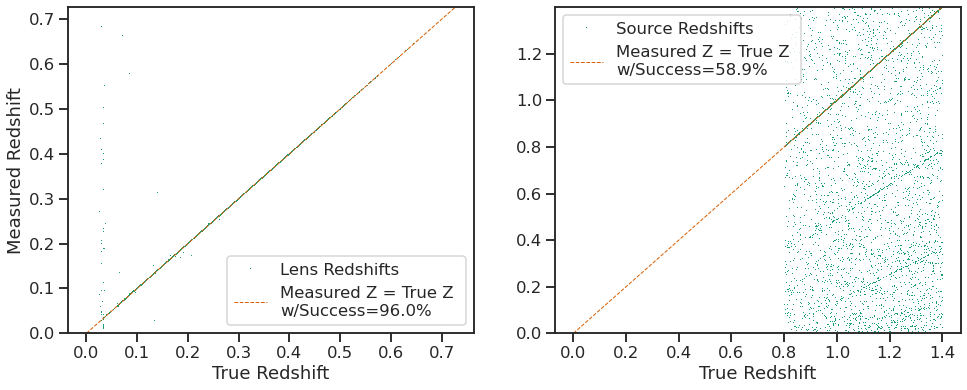

In [4]:
# Plot of true redshift vs redrock redshift

lensdiff = truthdata['LENS_Z'] - zbest_lens['Z']
srcdiff = truthdata_ELG['SOURCE_Z'] - zbest_source['Z']

srcsucc = np.where((np.abs(srcdiff) < 0.003) & (zbest_source['ZWARN'] == 0))[0]
lenssucc = np.where((np.abs(lensdiff) < 0.003) & (zbest_lens['ZWARN'] == 0))[0]

srcfail = np.where((np.abs(srcdiff) > 0.003) | (zbest_source['ZWARN'] != 0))[0]
lensfail = np.where((np.abs(lensdiff) > 0.003) | (zbest_lens['ZWARN'] != 0))[0]

fig, (lens, src) = plt.subplots(1,2, figsize=(16,6), sharey=False)

lens.plot(truthdata['LENS_Z'], zbest_lens['Z'], ',', label='Lens Redshifts')
lens.plot([0, max(truthdata['LENS_Z'])], [0, max(truthdata['LENS_Z'])], '--', lw=1, label='Measured Z = True Z \nw/Success={:.1f}%'.format(len(lenssucc)/len(lensdiff)*100))
lens.legend()
lens.set_xlabel('True Redshift')
lens.set_ylabel('Measured Redshift')
lens.set_ylim(0, max(truthdata['LENS_Z']))

src.plot(truthdata_ELG['SOURCE_Z'], zbest_source['Z'], ',', label='Source Redshifts')
src.plot([0, max(truthdata_ELG['SOURCE_Z'])], [0, max(truthdata_ELG['SOURCE_Z'])], '--', lw=1, label='Measured Z = True Z \nw/Success={:.1f}%'.format(len(srcsucc)/len(srcdiff)*100))
src.legend()
src.set_xlabel('True Redshift')
src.set_ylim(0, max(truthdata_ELG['SOURCE_Z']))


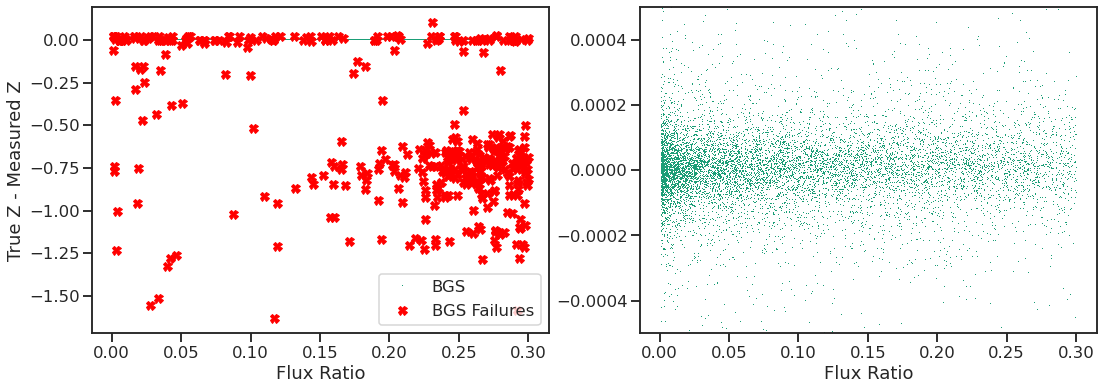

In [5]:
# Plot of BGS delta redshift vs. flux ratio

lensfail = np.where((np.abs(lensdiff) > 0.003) | (zbest_lens['ZWARN'] != 0))[0]

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,6))

ax1.plot(truthdata['FRATIO'], lensdiff, ',', label='BGS')
ax1.set_xlabel('Flux Ratio')
ax1.set_ylabel('True Z - Measured Z')
ax1.plot(truthdata['FRATIO'][lensfail], lensdiff[lensfail], 'rX', label='BGS Failures')
#ax1.title('Difference in BGS Redshift vs. Flux Ratio')

ax2.plot(truthdata['FRATIO'], lensdiff, ',')
ax2.set_xlabel('Flux Ratio')
ax2.set_ylim(-5e-4, 5e-4)

ax1.legend()

In [26]:
# Function to bin ELG redshift data
def ELGz_hist(data, deltaFratio, minFratio, maxFratio, squareroot=False):
    
    if squareroot:
        bins = np.arange(np.sqrt(minFratio), np.sqrt(maxFratio), deltaFratio)**2 #+ deltaFratio/2
    else:
        bins = np.arange(minFratio, maxFratio, deltaFratio) #+ deltaFratio/2
        
    hist, _ = np.histogram(data, bins=len(bins), range=(bins.min(), bins.max()))
    
    return hist, bins

def plt_fraction_secure(key, minF, maxF, deltaF, xlabel=None, twinaxis=False, ax=None, squared=False):
    
    from scipy.stats import poisson
    
    if xlabel is None:
        xlabel = key.lower()
    
    ELGsucc = np.where((np.abs(srcdiff) < 0.003) & (zbest_source['ZWARN'] == 0))[0]
    
    if squared:
        Hist, bins = ELGz_hist(truthdata_ELG[key], minFratio=minF, maxFratio=maxF, deltaFratio=deltaF, squareroot=True)
        Hist_good, _ = ELGz_hist(truthdata_ELG[key][ELGsucc], minFratio=minF, maxFratio=maxF, deltaFratio=deltaF, squareroot=True)
    
    else:
        Hist, bins = ELGz_hist(truthdata_ELG[key], minFratio=minF, maxFratio=maxF, deltaFratio=deltaF)
        Hist_good, _ = ELGz_hist(truthdata_ELG[key][ELGsucc], minFratio=minF, maxFratio=maxF, deltaFratio=deltaF)

    good = np.where(Hist != 0)[0]
    
    if not ax:
        fig, ax = plt.subplots(1,1,figsize=(9,6))

    if twinaxis:
        axtwin = ax.twinx()
        axtwin.plot(truthdata_ELG[key], srcdiff, 'X', color='dodgerblue', alpha=0.8, label='ELG delta Z')
        axtwin.set_ylabel('source delta z')
        axtwin.legend(loc='lower left')
    
    Ntot = Hist[good]
    Nsuccess = Hist_good[good]
    alphas = [1, 0.5, 0.25]
    
    for i, sigma in enumerate([0.68, 0.95, 0.997]):
        tot_lower, tot_upper = poisson.interval(sigma, Ntot)
        succ_lower, succ_upper = poisson.interval(sigma, Nsuccess)
        fraction = Nsuccess / Ntot
        frac_lower = fraction * np.sqrt((succ_lower*0 / Ntot)**2 + (tot_lower / Ntot)**2)
        frac_upper = fraction * np.sqrt((succ_upper*0 / Ntot)**2 + (tot_upper / Ntot)**2)
        frac_upper[frac_upper>=1] = 1

        ax.fill_between(bins[good], frac_lower, frac_upper, edgecolor='dimgrey', facecolor='lightblue', 
                        lw=2, label='{}% Confidence Interval'.format(sigma*100), alpha=alphas[i])
    
    #ax.plot(bins[good], fraction, '--', color='dimgrey')
    ax.set_xlabel('{}'.format(xlabel))
    ax.set_ylabel('Fraction of Secure Source Redshifts')
    ax.legend()

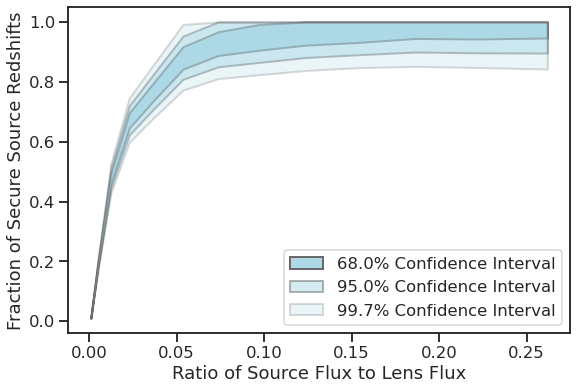

In [27]:
# Plot of histogram ratio of ELG outputs

minF = min(truthdata_ELG['FRATIO'])
maxF = max(truthdata_ELG['FRATIO'])
num = len(truthdata_ELG['FRATIO'])

deltaF = 0.04 #(maxF-minF)/(num)

fig, ax = plt.subplots(1,1,figsize=(9,6))

plt_fraction_secure('FRATIO', minF, maxF, deltaF, xlabel='Ratio of Source Flux to Lens Flux', squared=True, ax=ax)
ax.legend(loc='lower right')
plt.savefig('Fratio_plot.png', dpi=300)

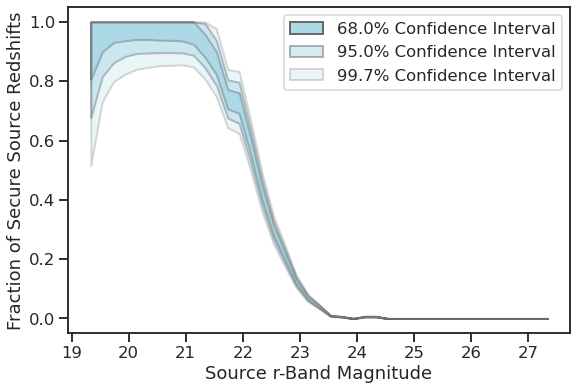

In [28]:
# Plot of secure redshifts vs. source mag

key = 'SOURCE_MAG'

minF = min(truthdata_ELG[key])
maxF = max(truthdata_ELG[key])
num = len(truthdata_ELG[key])

deltaF = .2 #(maxF-minF)/(num)

plt_fraction_secure(key, minF, maxF, deltaF, xlabel='Source r-Band Magnitude')
plt.savefig('sourceMag_plot.png', dpi=300)

(18.0, 20.0)

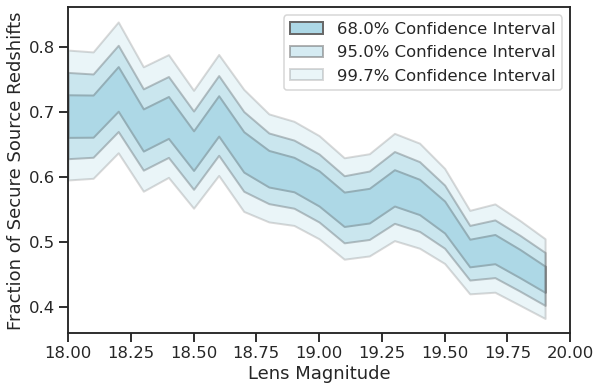

In [29]:
# Plot of secure redshifts vs. lens mag

key = 'LENS_MAG'

minF = min(truthdata_ELG[key])
maxF = max(truthdata_ELG[key])
num = len(truthdata_ELG[key])

deltaF = 0.1 #(maxF-minF)/(num)

fig, ax = plt.subplots(1,1,figsize=(9,6))

plt_fraction_secure(key, minF, maxF, deltaF, xlabel='Lens Magnitude', ax=ax)
ax.set_xlim(18,20)

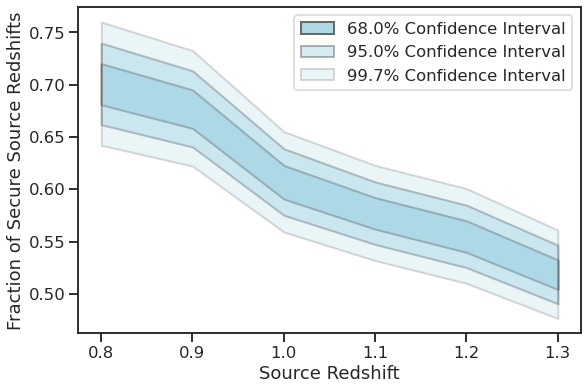

In [30]:
# Plot of secure redshifts vs. source redshift

key = 'SOURCE_Z'

minF = min(truthdata_ELG[key])
maxF = max(truthdata_ELG[key])
num = len(truthdata_ELG[key])

deltaF = 0.1 #(maxF-minF)/(num)

plt_fraction_secure(key, minF, maxF, deltaF, xlabel='Source Redshift')

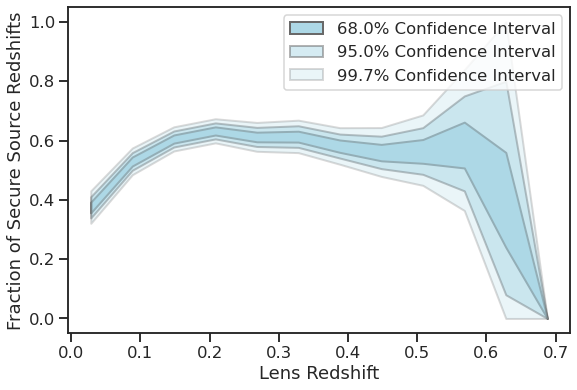

In [31]:
# Plot of secure redshifts vs. lens redshift

key = 'LENS_Z'

minF = min(truthdata_ELG[key])
maxF = max(truthdata_ELG[key])
num = len(truthdata_ELG[key])

deltaF = 0.06 #(maxF-minF)/(num)

plt_fraction_secure(key, minF, maxF, deltaF, xlabel='Lens Redshift')

In [32]:
# Get flux and wave data
chunk = 0 # Change to chunk that you want to look at spectra in

combflux = fits.getdata(os.path.join(os.getcwd(), '..', 'lenssource-truth.fits'), 'FLUX')
combwave = fits.getdata(os.path.join(os.getcwd(), '..', 'lenssource-truth.fits'), 'WAVE')
BGSflux = fits.getdata(os.path.join(os.getcwd(), '..', 'lenssource-truth.fits'), 'BGSFLUX')
ELGflux = fits.getdata(os.path.join(os.getcwd(), '..', 'lenssource-truth.fits'), 'ELGFLUX')

spectra = desispec.io.read_spectra(os.path.join(os.getcwd(), '..', 'lenssource-spectra-chunk00{}.fits'.format(chunk)))

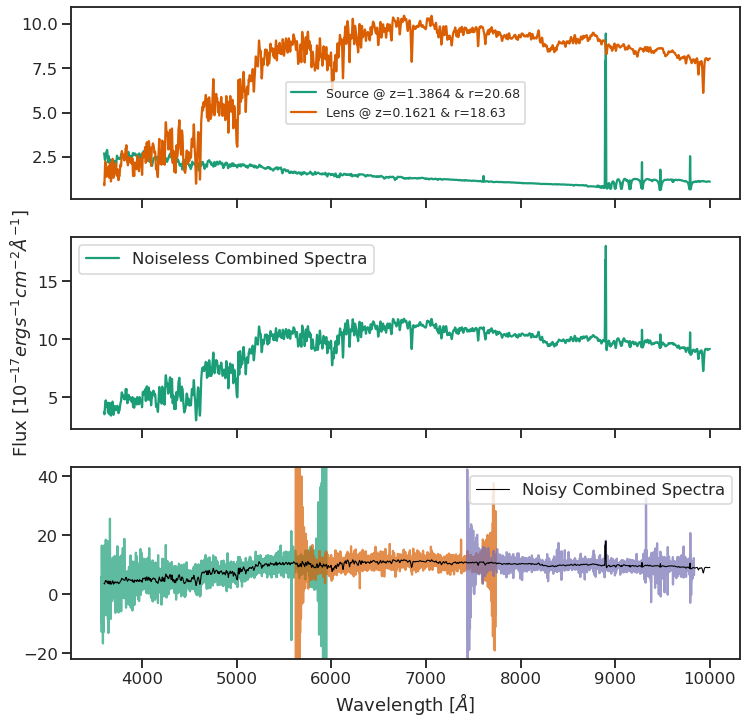

In [34]:
# Plot spectra

## Top panel is source and lens 
## Observed Noiseless Spectrum
## Observed Noisy Spectrum
## No Title but put magnitude in legend

spec = 11 # 0-500, if there are more than 500 spectra, change the chunk variable

fig, (E, B, N) = plt.subplots(3,1,figsize=(12,12), sharey=False, sharex=True)
E.plot(combwave, ELGflux[spec], label='Source @ z={:.4f} & r={:.2f}'.format(truthdata['SOURCE_Z'][spec], truthdata['SOURCE_MAG'][spec]))
E.plot(combwave, BGSflux[spec], label='Lens @ z={:.4f} & r={:.2f}'.format(truthdata['LENS_Z'][spec], truthdata['LENS_MAG'][spec]))
#E.plot(combwave, combflux[spec], label='Combined Spectra', alpha=0.5)
E.legend(fontsize='x-small')
#E.set_ylabel('Flux')
#E.set_title('Flux Ratio: {:.2f}'.format(truthdata['FRATIO'][spec]))


B.plot(combwave, combflux[spec], label='Noiseless Combined Spectra')
B.legend()
B.set_ylabel('Flux [$10^{-17} erg s^{-1} cm^{-2} \AA^{-1}$]')
N.set_xlabel('Wavelength [$\AA$]')

for band in spectra.bands:
    N.plot(spectra.wave[band], spectra.flux[band][spec], alpha=0.7)

N.plot(combwave, combflux[spec], color='k', linewidth=1.1, label='Noisy Combined Spectra')
N.set_ylim(min(combflux[spec]) - 25, max(combflux[spec]) + 25)
N.legend()

fig.savefig('sampleSpectra.png', dpi=300)